# PyTorch - Autograd (is what we need.)

Advanced Learning 2024





For SUBMISSION:  
  
Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 311118780
~~~

~~~
STUDENT GIT LINK: https://github.com/MaorMoshe11
~~~

In Addition, don't forget to add your ID to the files:  
`PS1_Part3_Autograd_2024_ID_311118780.html`  



This part of the problem-set is divided into 2 sections: (a) a short introduction to PyTorch autograd, and (b) some practice questions.      
The practice questions cover calculating the gradients and updating the weights of a statistical model (linear regression), with and without PyTorch autograd.

##  A Short Intro to PyTorch Autograd

In PyTorch, autograd, short for automatic differentiation, is a core functionality that empowers you to efficiently calculate gradients during deep learning model training. It acts as a computational engine that automatically tracks the operations performed on your tensors and calculates the gradients of any loss function with respect to the model's learnable parameters.

**Why is Autograd Important?**

* Gradient Calculation: Deep learning relies heavily on gradient-based optimization algorithms like stochastic gradient descent (SGD). These algorithms adjust the weights and biases (learnable parameters) of your model based on the gradients of the loss function. Autograd automates this process, saving you from manually calculating complex derivatives.
* Efficient Backpropagation: Backpropagation is the algorithm at the heart of training deep neural networks. It propagates the error (loss) backward through the network, allowing the model to adjust its parameters in the direction that minimizes the loss. Autograd streamlines this process, making training more efficient.

**How Does Autograd Work?**

* Tracking Operations: When you enable autograd mode (with `torch.autograd.record_grad()`), PyTorch creates a computational graph in the background. This graph tracks all the operations performed on your tensors

* Backward Pass: Once you calculate a loss function (which typically depends on the output of your model), you can call the `backward()` method on the loss tensor. This triggers the backward pass through the computational graph.

* Gradient Calculation: As the backward pass traverses the graph, autograd computes the gradients of the loss function with respect to each learnable parameter in the network. These gradients indicate how much a specific parameter contributed to the overall loss.

* Parameter Update: By utilizing these gradients, optimization algorithms like SGD update the model's learnable parameters in a direction that minimizes the loss function. This iterative process continues until the model converges (achieves a desired level of performance).

**Key Points about Autograd:**

* Automatic
* Only for Learnable Parameters: Autograd tracks gradients only for tensors that have `requires_grad=True`.
* Dynamic vs. Static Graphs (Optional): PyTorch offers both dynamic computational graphs (eager execution) and static graphs (graph mode) for model development.



In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device}!")


Using cuda!


##  0. Loading data and defining our model and loss

Load the California Housing Market dataset into a panda's DataFrame.  
In addition, scale the data (why?).

In [ ]:
# Import the dataset.
cali_train_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
train_df = pd.read_csv(filepath_or_buffer=cali_train_path).drop(['longitude','latitude'],axis=1)
train_df_norm=(train_df-train_df.mean(axis=0))/train_df.std(axis=0) # column-wise operators
# Scale the labels:
print(f"Dataset dimension: {train_df_norm.shape}")
train_df_norm.head()

Dataset dimension: (17000, 7)


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522
1,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713
2,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430
3,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480
4,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593


We define a linear model to fit the scaled median house value to our data:  

**Our model :**.    

 $$\text{median_house_value}_i=y_i = \beta_0+	\beta_1\text{housing_median_age}_i+ 	\beta_2\text{total_rooms}_i+ 	\beta_3\text{total_bedrooms}_i+ 	\beta_4\text{population}_i+ 	\beta_5\text{households}_i+ 	\beta_6\text{median_income}_i 	$$

**Our loss :**  
$$
\hat{L}_i(y_i,\hat{y}_i) = MSE(\text{y}_i,\hat{\text{y}}_i)
$$


## 1.  Manually Calculating the Gradients and Updating the Weights



Here we take a step back, and implement forward and backward propogation manually (so we can fully appreciate the autograd later...).

First, create numpy arrays for our data (X) and target (Y):

In [ ]:
X = train_df_norm.drop(['median_house_value'],axis=1).to_numpy()
X =  np.c_[  np.ones(X.shape[0]), X ] # adding a column of "1"s for intercept
Y = train_df_norm['median_house_value']

print(f"X dimension: {X.shape}")
print(f"Y dimension: {Y.shape}")

X dimension: (17000, 7)
Y dimension: (17000,)


### 1.1 Calculating the weights analytically (15pts)
Apply linear algebra operations to `X` and `Y` to analytically solve the linear regression problem (solve for `W`).   
Please use only numpy. Round the weights to 3 decimal places.  

In [ ]:
#### SOLUTION REQUIRED ####
t1 = time.time()

weights_rounded = np.linalg.inv(X.T@X)@X.T@Y
print(f"Total process time: {round(time.time() - t1,3)}")
print(f"The estimated weights using the analytic solution:\n {weights_rounded.round(3)}")

Total process time: 0.01
The estimated weights using the analytic solution:
 [ 0.     0.204 -0.375  0.362 -0.347  0.422  0.79 ]


Visualizing the errors:

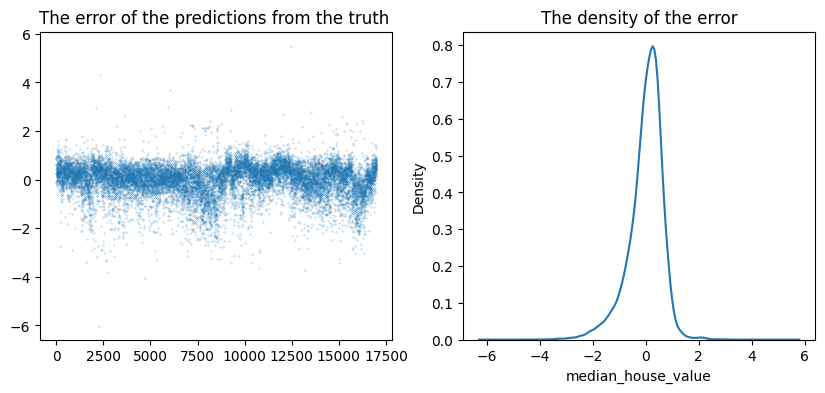

In [ ]:
# Plot the errors and density (sanity check):
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
error = (np.matmul( X, weights_rounded)-Y)
ax1.scatter(range(Y.shape[0]), error ,s=0.05,alpha=0.7)
ax1.set_title("The error of the predictions from the truth ")
sns.kdeplot(error,ax=ax2)
ax2.set_title("The density of the error")
fig.show()


### 1.2 Calculating the weights using numpy and gradient descent (30pts)

Now you are ready to implement an algorithm that iteratively calculates the weights using numpy and gradient descent.

Please fill in your code in the `### YOUR CODE HERE` sections in the code block below.   
Please don't change the other parts of the code (unless specified).  

An epoch in machine learning means one complete pass of the training dataset through the algorithm.   

While developing your code, you may reduce the number of epochs.   
However, for final output please use the pre-defined epochs number.      






In [ ]:
#### SOLUTION REQUIRED ####

t2 = time.time()

# Randomly initialize weights using numpy
b0 = np.random.rand()
b1 = np.random.rand()
b2 = np.random.rand()
b3 = np.random.rand()
b4 = np.random.rand()
b5 = np.random.rand()
b6 = np.random.rand()


# Set learning rate (this can be a little fiddly, requires some tunning)
# Tip: start with a very small steps...

learning_rate = 0.01

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    Y_pred = np.dot(X,np.array([b0, b1, b2, b3, b4, b5, b6])) # FILL IN THE MISSING CODE

    # Compute and print loss
    loss = np.mean((Y_pred-Y)**2)
    if t % 1000 == 0:
        print(f"Epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = 2 * (Y_pred-Y) / Y.shape[0]
    grad_b0 = np.dot(grad_y_pred,X[:,0])
    grad_b1 = np.dot(grad_y_pred,X[:,1])
    grad_b2 = np.dot(grad_y_pred,X[:,2])
    grad_b3 = np.dot(grad_y_pred,X[:,3])
    grad_b4 = np.dot(grad_y_pred,X[:,4])
    grad_b5 = np.dot(grad_y_pred,X[:,5])
    grad_b6 = np.dot(grad_y_pred,X[:,6])

    # Update weights
    b0 -= learning_rate * grad_b0
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    b3 -= learning_rate * grad_b3
    b4 -= learning_rate * grad_b4
    b5 -= learning_rate * grad_b5
    b6 -= learning_rate * grad_b6


print(f"Result: y_hat = {b0} x0 + {b1} x1 + {b2} x2 + {b3} x3\n + {b4} x4 + {b5} x5 + {b6} x6 \n")
print(f"Total process time: {round(time.time() - t2,3)}")

weights_gd_rounded = np.array([b0,b1,b2,b3,b4,b5,b6])
print(f"The estimated weights using the gradient descent solution:\n {weights_gd_rounded.round(3)}")

Epoch:0, loss:3.7227993543558693
Epoch:1000, loss:0.4334580483760067
Epoch:2000, loss:0.42944544418048536
Epoch:3000, loss:0.42895089147748555
Epoch:4000, loss:0.4287980324813924
Result: y_hat = 3.469888494762827e-16 x0 + 0.2032421523263895 x1 + -0.36227621247097913 x2 + 0.3046015534117801 x3
 + -0.3570379906564288 x4 + 0.4760989864983132 x5 + 0.7863927906586521 x6 

Total process time: 14.59
The estimated weights using the gradient descent solution:
 [ 0.     0.203 -0.362  0.305 -0.357  0.476  0.786]


### 1.3 Calculating the weights using PyTorch Tensors and gradient descent (25pts)

Here you are asked to implement the same manual gradient algorithm as above.  
However, this time please use PyTorch tensors and operators (instead of numpy).  

In [ ]:
#### SOLUTION REQUIRED ####

# Creating data and target tensors:
tX = torch.tensor(X, dtype=torch.float32)  # Convert X to float32
tY = torch.tensor(Y, dtype=torch.float32)  # Convert Y to float32

t3 = time.time()

# Randomly initialize weights using PyTorch
tb0 = torch.rand(1,requires_grad=False)
tb1 = torch.rand(1,requires_grad=False)
tb2 = torch.rand(1,requires_grad=False)
tb3 = torch.rand(1,requires_grad=False)
tb4 = torch.rand(1,requires_grad=False)
tb5 = torch.rand(1,requires_grad=False)
tb6 = torch.rand(1,requires_grad=False)

# Set learning rate
learning_rate = 0.01

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    weights = torch.stack([tb0, tb1, tb2, tb3, tb4, tb5, tb6]).squeeze().to(torch.float32)
    tY_pred = torch.matmul(tX,weights) # FILL IN THE MISSING CODE

    # Compute and print loss
    loss = torch.mean((tY_pred-tY)**2)
    # FILL IN THE MISSING CODE
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = 2 * (tY_pred-tY) / tY.shape[0]
    # print(grad_y_pred.sum()
    grad_b0 = torch.sum(grad_y_pred * tX[:, 0])
    grad_b1 = torch.sum(grad_y_pred * tX[:, 1])
    grad_b2 = torch.sum(grad_y_pred * tX[:, 2])
    grad_b3 = torch.sum(grad_y_pred * tX[:, 3])
    grad_b4 = torch.sum(grad_y_pred * tX[:, 4])
    grad_b5 = torch.sum(grad_y_pred * tX[:, 5])
    grad_b6 = torch.sum(grad_y_pred * tX[:, 6])


    # Update weights
    tb0 -= learning_rate * grad_b0
    tb1 -= learning_rate * grad_b1
    tb2 -= learning_rate * grad_b2
    tb3 -= learning_rate * grad_b3
    tb4 -= learning_rate * grad_b4
    tb5 -= learning_rate * grad_b5
    tb6 -= learning_rate * grad_b6

print(f"Result: y_hat = {tb0} x0 + {tb1} x1 + {tb2} x2 + {tb3} x3\n + {tb4} x4 + {tb5} x5 + {tb6} x6 \n")
print(f"Total process time: {round(time.time() - t3,3)}")

weights_gd_tensors_rounded = np.array([tb0.item(),tb1.item(),tb2.item(),tb3.item(),
                                       tb4.item(),tb5.item(),tb6.item()])
print(f"The estimated weights using the gradient descent on tensors:\n {weights_gd_tensors_rounded.round(3)}")

epoch:0, loss:3.463514804840088
epoch:1000, loss:0.43151047825813293
epoch:2000, loss:0.4291265904903412
epoch:3000, loss:0.4288370609283447
epoch:4000, loss:0.42873913049697876
Result: y_hat = tensor([4.7870e-09], device='cuda:0') x0 + tensor([0.2034], device='cuda:0') x1 + tensor([-0.3648], device='cuda:0') x2 + tensor([0.3154], device='cuda:0') x3
 + tensor([-0.3551], device='cuda:0') x4 + tensor([0.4659], device='cuda:0') x5 + tensor([0.7871], device='cuda:0') x6 

Total process time: 4.714
The estimated weights using the gradient descent on tensors:
 [ 0.     0.203 -0.365  0.315 -0.355  0.466  0.787]


### 1.4 Calculating the weights using PyTorch Autograd! (15pts)

Lastly, you can finally make a full transition to PyTorch autograd framework.   
Please replace your manual gradient calculations with PyTorch's automatic gradient tracking.   
In addition, instead of declaring the parameters separately, we will use one tensor to represent all of the model's parameters.  

In [ ]:
# FILL IN THE MISSING CODE

t4 = time.time()

# Randomly initialize weights using PyTorch
# we can use 1x7 tensor for all the weights. Make sure `requires_grad = True`.
tb = torch.rand(7,requires_grad=True)

# Set learning rate
learning_rate = 0.01 # FILL IN THE MISSING CODE
# Set number of epochs:
epochs = int(1e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):

    # Forward pass: compute predicted y
    tY_pred = torch.matmul(tX,tb) # FILL IN THE MISSING CODE

    # Compute and print loss
    loss = torch.mean((tY_pred - tY)**2)
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss.item()}")

    # Backprop to compute gradients of betas with respect to loss
    loss.backward()

    with torch.no_grad():
        # Update weights
        tb -= learning_rate * tb.grad
        tb.grad = None # manually clear gradient after update


print(f"Result: betas = {tb} \n")
print(f"Total process time: {round(time.time() - t4,3)}")

weights_autograd_rounded = tb.cpu().detach().numpy()
print(f"The estimated weights using the pytorch autograd:\n {weights_autograd_rounded.round(3)}")

epoch:0, loss:4.4712324142456055
Result: betas = tensor([ 5.6244e-09,  2.0717e-01, -1.9134e-01,  7.2053e-02, -3.2896e-01,
         5.1761e-01,  7.4824e-01], device='cuda:0', requires_grad=True) 

Total process time: 0.664
The estimated weights using the pytorch autograd:
 [ 0.     0.207 -0.191  0.072 -0.329  0.518  0.748]


### 1.5 Conclusion (15pts)

1. Which method is the most accurate in finding the "true" weights? Why? Is it always applicabale? Hint - you should think about it from a statistical theory point of view.
2. Why did we scale the data ?  (answer with respect to the model/algorithm)
3. Do you think our model specification produced good results?  Why or why not? Justify your answer.
4. What can you say about the total process times between methods?
5. Can you suggest some improvements to the model definition?
6. Can you suggest some improvements to the solution algorithm?

YOUR ANSWERS HERE

1. Analytic approach: The analytic solution computes the exact solution to the least squares problem using the "Best Linear Unbiased Estimator" (BLUE). It is the most accurate estimator. However, it is computationally expensive for large datasets due to the matrix inversion

2. Scaling ensure all the variables on the same scale, preventing larger valued variables from domaining the gradient updates. This improves the convergence and numrical stabillity. (I added a prove under the dull answer)

3. In general, there are signs for good fit. The first is the residual that they are quit small and they are gaussian distributed. To get more secure about this, i would vizualise the data, try maybe a set of polynoms isnted of linear function to describe it and check the loss.

4. improvements to the model definition
  -  Analytical solution - Most accurate, might be extremly slow for big data sets. Senstive for multiconarity and un-invertable
  - GD - better for large datasets, faster then the analytical solution and litlle less acurate (with big enough tolarence or C.I, the GD is better then the analytic in all scales).
  -  Pytorch Autograd- Introduces overhead due to gradient tracking but simplifies gradient computation for complex models. Explain: When requires_grad=True, PyTorch tracks all operations on tensors to build a computational graph. This consumes memory and adds computation time compared to manual gradient calculation. Hence, in a simaple linear model it might be fast, but myabe in more complex it will be unefficient.

5. Potential Model Improvements -
  -  Add interaction terms or higher-order polynomials for non-linear relationships.
  -  Use regularization (e.g., Ridge or Lasso regression) to handle multicollinearity and improve generalization.
  -  Perform feature selection with R2 elimination or even PCA to remove irrelevant or redundant features

6. Potential Algorithm Improvements
  - Use adaptive optimizers (e.g., Adam, RMSProp) to dynamically adjust learning rates.
  - For large datasets, implement Stochastic Gradient Descent (SGD) or mini-batch gradient descent for faster convergence.
  - Monitor convergence with early stopping or a dynamic learning rate scheduler.


## Why scaling is good ? mathmatical explain

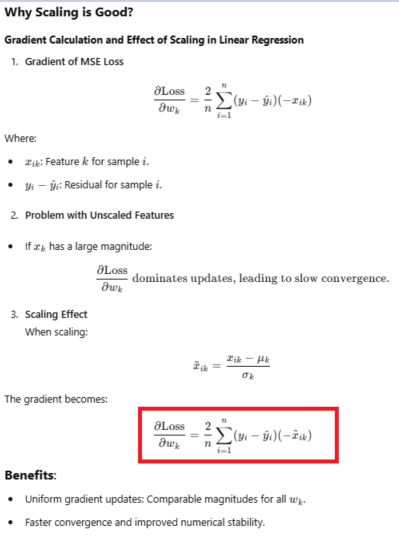

PART 2: Coming soon...

In [ ]:
#make html of /content/PS1_Part3_Autograd_2024_ID_311118780.ipynb
!jupyter nbconvert --to html /content/PS1_Part3_Autograd_2024_ID_311118780.ipynb

[NbConvertApp] Converting notebook /content/PS1_Part3_Autograd_2024_ID_311118780.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 525637 bytes to /content/PS1_Part3_Autograd_2024_ID_311118780.html
